In [2]:
import glob
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import svm

from PIL import Image
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
TRAINING_CSV_PATH = 'C:/Users/jean/Documents/hands-on-2021/notebooks/GTSRB/Final_Training/Images/*/*.csv'

IMAGE_WIDTH = 30
IMAGE_HEIGHT = IMAGE_WIDTH

In [6]:
def build_images_database(path):
    """Build a pandas DataFrame with all images information.
    
    Parameters
    ----------
    path: path pattern to read csv files containing images information
    
    Returns
    -------
    A pandas DataFrame with one line per image
    """
    df_list = []
    for filename in glob.glob(path):
        df = pd.read_csv(filename, sep=';')
        df['path'] = os.path.dirname(filename) + '/' + df['Filename']
        df_list.append(df)
    
    return pd.concat(df_list, ignore_index=True)


def build_images_list(filename_list, boxes_list=None):
    """Build a list of images as Numpy array
    
    Parameters
    ----------
    filename_list: list of images filenames
    boxes_list: optional list of boxes for clipping within images. Boxes are 4-tuples (x1, y1, x2, y2).
    
    Returns
    -------
    A list of images as Numpy arrays
    
    """
    
    # If no boxes_list is given, generate a fake boxes list with None boxes
    # image.resize will take full size images if argument box == None
    if boxes_list is None:
        boxes_list = [None] * len(filename_list)
        
    assert len(filename_list) == len(boxes_list), "filenames and boxes lists must have the same length"
    
    images_list = []
    for (filename, image_box) in zip(filename_list, boxes_list):
        image = Image.open(filename)
        image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
        image = np.array(image)
        image = image.flatten()
        images_list.append(image)
        
    return images_list

def build_classes_array(df, col_name='ClassId'):
    """Build a vector (numpy array) of classes
    
    Parameters
    ----------
    df: pandas DataFrame with a column containing classes id
    
    Returns
    -------
    Numpy array with image classes
    
    """
    return df[col_name].values

In [27]:
images_df = build_images_database(TRAINING_CSV_PATH)
images_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,29,30,5,6,24,25,0,C:/Users/jean/Documents/hands-on-2021/notebook...
1,00000_00001.ppm,30,30,5,5,25,25,0,C:/Users/jean/Documents/hands-on-2021/notebook...
2,00000_00002.ppm,30,30,5,5,25,25,0,C:/Users/jean/Documents/hands-on-2021/notebook...
3,00000_00003.ppm,31,31,5,5,26,26,0,C:/Users/jean/Documents/hands-on-2021/notebook...
4,00000_00004.ppm,30,32,5,6,25,26,0,C:/Users/jean/Documents/hands-on-2021/notebook...


In [28]:
images_list = build_images_list(images_df['path'].values)


data = np.array(images_list)
labels = build_classes_array(images_df)

print(data.shape, labels.shape)

(39209, 2700) (39209,)


In [29]:
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 2700) (7842, 2700) (31367,) (7842,)


In [30]:
C = 1.0 
svm_lin = svm.LinearSVC(C=C).fit(X_train, y_train)

C:\Users\jean\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [31]:
print(svm_lin.score(X_test,y_test))

0.9062739097169089


In [32]:
y_pred = svm_lin.predict(X_test)

In [33]:
import pickle

In [34]:
filename = 'C:/Users/jean/Documents/hands-on-2021/notebooks/SVM.sav'
pickle.dump(svm_lin, open(filename, 'wb'))

In [35]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 26   6   1 ...   0   0   0]
 [  3 428  14 ...   0   0   0]
 [  0  14 380 ...   0   1   0]
 ...
 [  0   0   0 ...  54   1   0]
 [  0   0   1 ...   0  41   1]
 [  0   0   0 ...   0   0  39]]
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        38
           1       0.83      0.86      0.85       496
           2       0.87      0.84      0.86       450
           3       0.81      0.76      0.79       280
           4       0.86      0.84      0.85       418
           5       0.70      0.85      0.77       364
           6       0.95      0.93      0.94        59
           7       0.86      0.85      0.85       278
           8       0.87      0.87      0.87       301
           9       0.89      0.94      0.91       268
          10       0.97      0.97      0.97       370
          11       0.95      0.95      0.95       236
          12       0.99      0.96      0.98       450
          13       0.98      0.98      0.98       4

In [36]:
accuracy_df = pd.DataFrame()
accuracy_df['actual'] = y_test
accuracy_df['predicted'] = y_pred

Le taux de précision du SVM est : 90.63%


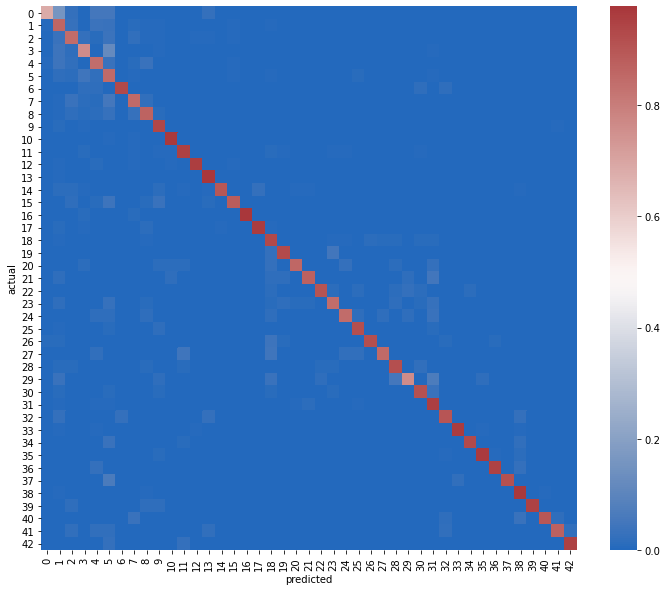

In [37]:
import seaborn as sns
import sklearn
cm = sklearn.metrics.accuracy_score(y_test, y_pred)*100
print("Le taux de précision du SVM est : {:.2f}%".format(cm))
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'], normalize='index'),
            cmap='vlag',
            ax=ax);

# testing

In [7]:
test_images_df = pd.read_csv('C:/Users/jean/Documents/hands-on-2021/notebooks/GT-final_test.csv', sep=';')
test_images_df['path']=test_images_df['Filename'].apply(lambda x:'C:/Users/jean/Documents/hands-on-2021/notebooks/GTSRB/Final_Test/Images/'+x)
test_images_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000.ppm,53,54,6,5,48,49,16,C:/Users/jean/Documents/hands-on-2021/notebook...
1,00001.ppm,42,45,5,5,36,40,1,C:/Users/jean/Documents/hands-on-2021/notebook...
2,00002.ppm,48,52,6,6,43,47,38,C:/Users/jean/Documents/hands-on-2021/notebook...
3,00003.ppm,27,29,5,5,22,24,33,C:/Users/jean/Documents/hands-on-2021/notebook...
4,00004.ppm,60,57,5,5,55,52,11,C:/Users/jean/Documents/hands-on-2021/notebook...


In [8]:
#Test model
test_list= build_images_list(test_images_df['path'].values)
test_data=np.array(test_list)
test_labels=build_classes_array(test_images_df)

In [12]:
import pickle 

# load the model from disk
loaded_model = pickle.load(open('C:/Users/jean/Documents/hands-on-2021/notebooks/SVM.sav', 'rb'))
result = loaded_model.score(test_data, test_labels)
print(result)

0.808313539192399


In [16]:
predicted = loaded_model.predict(test_data)

In [17]:
accuracy_df = pd.DataFrame()
accuracy_df['actual'] = test_labels
accuracy_df['predicted'] = predicted

Le taux de précision du SVM est : 80.83%


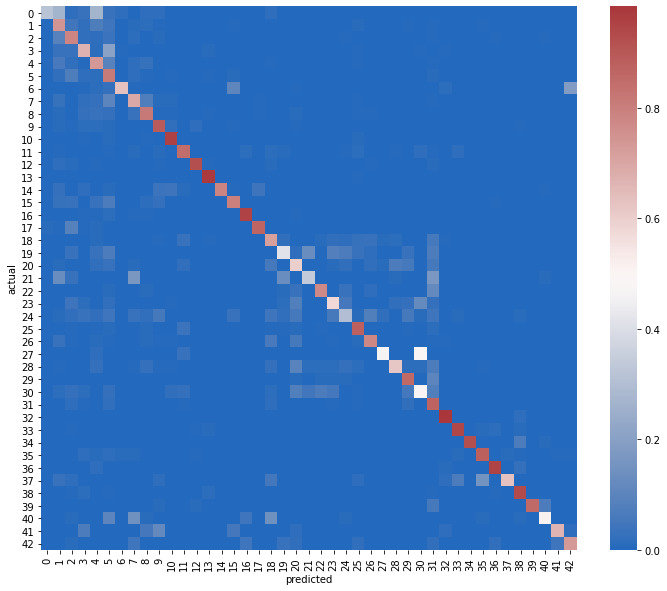

In [19]:
import seaborn as sns
import sklearn
cm = sklearn.metrics.accuracy_score(test_labels, predicted)*100
print("Le taux de précision du SVM est : {:.2f}%".format(cm))
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'], normalize='index'),
            cmap='vlag',
            ax=ax);